In [ ]:
#############################################################################################
#  Developed by Jonathan Ojeda 28-03-2021 QAAFI UQ
#  Functionalities:
#  - Read APSIM Next Gen db file and work with it
#  - Work with Initial report, daily report and harvest report from APSIM
#  - Compare climate and soil data from weather stations and observation with global datasets
#############################################################################################

In [215]:
#Import packages required
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import MathsUtilities as MUte
import matplotlib.patheffects as path_effects
import GraphHelpers as GH
import matplotlib.lines as mlines
import seaborn as sns
from numpy  import array
import matplotlib.ticker as ticker
%matplotlib inline

#Extend screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [89]:
con = sqlite3.connect(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\test\newdata\Potato.db')
Simulations = pd.read_sql("Select * from _Simulations",con)
Simulations.set_index('ID',inplace=True)
Factors = pd.read_sql("Select * from _Factors",con)
Factors.set_index('SimulationID',inplace=True)
LocList = pd.read_excel(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\List of locations.xlsx')
LocList.set_index('metfile',inplace=True)

import re
def extractLocation(lcn):
    lcn = lcn.replace('MET files\\','')
    lcn = re.sub('\d','',lcn)
    lcn = lcn.replace('.met','')
    return lcn
def extractfileName(fn):
    fn = fn.replace('MET files\\','')
    fn = fn.replace('.met','')
    return fn

Obs = pd.read_excel(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Observed.xlsx')

InitialReport = pd.read_sql("Select * from InitialReport",con)
InitialReport.loc[:,'SimulationName'] = [Simulations.loc[InitialReport.loc[x,'SimulationID'],'Name'] for x in InitialReport.index]
InitialReport.drop(['CheckpointID','Zone','Nitrogen','01','1','_','Water','PlantDensity'],axis=1,inplace=True)
InitialReport.set_index('SimulationID',inplace=True)
InitialReport.loc[:,'Location'] = [extractLocation(x) for x in InitialReport.loc[:,'Weather.FileName']]
InitialReport.loc[:,'FileName'] = [extractfileName(InitialReport.loc[x,'Weather.FileName']) for x in InitialReport.index]
InitialReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Country Loc'] = [InitialReport.loc[x,'Country'] + ' ' + InitialReport.loc[x,'Loc'] for x in InitialReport.index] 

DailyReport = pd.read_sql("Select * from DailyReport",con)
DailyReport.loc[:,'SimulationName'] = [Simulations.loc[DailyReport.loc[x,'SimulationID'],'Name'] for x in DailyReport.index]
DailyReport.drop(['CheckpointID','Zone','Nitrogen','01','1','_','Water','PlantDensity'],axis=1,inplace=True)
DailyReport.set_index('SimulationID',inplace=True)

DailyPreObs = pd.read_sql("Select * from TimeSeriesData",con)
DailyPreObs.loc[:,'SimulationName'] = [Simulations.loc[DailyPreObs.loc[x,'SimulationID'],'Name'] for x in DailyPreObs.index]
DailyPreObs.set_index('SimulationID',inplace=True)
DailyPreObs.drop_duplicates(inplace=True)

HarvestReport = pd.read_sql("Select * from HarvestReport",con)
HarvestReport.loc[:,'SimulationName'] = [Simulations.loc[HarvestReport.loc[x,'SimulationID'],'Name'] for x in HarvestReport.index]
HarvestReport.drop(['CheckpointID','Zone','Nitrogen','01','1','_','Water','PlantDensity'],axis=1,inplace=True)
HarvestReport.loc[:,'PlantPopn'] = 1/((HarvestReport.loc[:,'RowWidth']/1000)* (HarvestReport.loc[:,'InterRowPlantSpace']/1000))
HarvestReport.loc[:,'StemPopn'] = HarvestReport.loc[:,'StemPerTuber'] *  HarvestReport.loc[:,'PlantPopn']
HarvestReport.loc[:,'Location'] = [extractLocation(x) for x in HarvestReport.loc[:,'Weather.FileName']]
HarvestReport.set_index('SimulationID',inplace=True)
HarvestReport.loc[:,'FileName'] = [extractfileName(HarvestReport.loc[x,'Weather.FileName']) for x in HarvestReport.index]
HarvestReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Country Loc'] = [HarvestReport.loc[x,'Country'] + ' ' + HarvestReport.loc[x,'Loc'] for x in HarvestReport.index]

HarvestPreObs = pd.read_sql("Select * from FinalYieldData",con)
HarvestPreObs.loc[:,'SimulationName'] = [Simulations.loc[HarvestPreObs.loc[x,'SimulationID'],'Name'] for x in HarvestPreObs.index]
HarvestPreObs.set_index('SimulationID',inplace=True)
HarvestPreObs.drop_duplicates(inplace=True)

data = pd.merge(left=HarvestReport, right=DailyPreObs, left_on='SimulationName', right_on='SimulationName')
data.rename(columns={'Observed.Potato.Tuber.LiveFWt':'obsFTuWt','Predicted.Potato.Tuber.LiveFWt':'preFTuWt',
                    'Observed.Potato.Tuber.Live.Wt':'obsTuWt','Predicted.Potato.Tuber.Live.Wt':'preTuWt',
                    'Observed.Potato.TotalLive.Wt':'obsToWt','Predicted.Potato.TotalLive.Wt':'preToWt',
                    'Observed.Potato.Leaf.LAI':'obsLAI','Predicted.Potato.Leaf.LAI':'preLAI',
                    'Observed.Potato.Tuber.Live.N':'obsTuLN','Predicted.Potato.Tuber.Live.N':'preTuLN',
                    'Observed.Potato.TotalLive.N':'obsToLN','Predicted.Potato.TotalLive.N':'preToLN',
                    'Weather.Latitude':'lat'}, inplace=True)

In [62]:
# #Adding month and day of sowing as columns
# data['SowDate0']  = pd.to_datetime(data['PlantingDate'])
# data['SowDate'] = data['SowDate0'].dt.strftime('%Y-%m-%d')
# data['month'] = data['SowDate'].str[5:7]
# data['day'] = data['SowDate'].str[8:10]

In [196]:
climate = pd.merge(left=InitialReport, right=DailyReport, left_on='SimulationName', right_on='SimulationName')

climate.drop(['Experiment_x', 'FolderName_x', 'Cultivar_x', 'Weather.FileName', 'Weather.CO2',
 'Weather.Amp', 'Weather.Tav', 'TotalSoilN_x', 'Soil.Physical.Depth(1)', 'Soil.Physical.Depth(2)', 'Soil.Physical.Depth(3)',
 'Soil.Physical.Depth(4)', 'Soil.Physical.Depth(5)', 'Soil.Physical.Depth(6)', 'Soil.Physical.Thickness(1)',
 'Soil.Physical.Thickness(2)', 'Soil.Physical.Thickness(3)', 'Soil.Physical.Thickness(4)', 'Soil.Physical.Thickness(5)',
 'Soil.Physical.Thickness(6)', 'Soil.Physical.PotatoSoil.LL(1)', 'Soil.Physical.PotatoSoil.LL(2)',
 'Soil.Physical.PotatoSoil.LL(3)', 'Soil.Physical.PotatoSoil.LL(4)', 'Soil.Physical.PotatoSoil.LL(5)',
 'Soil.Physical.PotatoSoil.LL(6)', 'Soil.Physical.PotatoSoil.KL(1)', 'Soil.Physical.PotatoSoil.KL(2)',
 'Soil.Physical.PotatoSoil.KL(3)', 'Soil.Physical.PotatoSoil.KL(4)', 'Soil.Physical.PotatoSoil.KL(5)',
 'Soil.Physical.PotatoSoil.KL(6)', 'Soil.Physical.PotatoSoil.XF(1)', 'Soil.Physical.PotatoSoil.XF(2)',
 'Soil.Physical.PotatoSoil.XF(3)', 'Soil.Physical.PotatoSoil.XF(4)', 'Soil.Physical.PotatoSoil.XF(5)',
 'Soil.Physical.PotatoSoil.XF(6)', 'Soil.Physical.DUL(1)', 'Soil.Physical.DUL(2)', 'Soil.Physical.DUL(3)',
 'Soil.Physical.DUL(4)', 'Soil.Physical.DUL(5)', 'Soil.Physical.DUL(6)', 'Soil.Chemical.NO3N(1)',
 'Soil.Chemical.NO3N(2)', 'Soil.Chemical.NO3N(3)', 'Soil.Chemical.NO3N(4)', 'Soil.Chemical.NO3N(5)',
 'Soil.Chemical.NO3N(6)', 'Soil.Chemical.NH4N(1)', 'Soil.Chemical.NH4N(2)', 'Soil.Chemical.NH4N(3)',
 'Soil.Chemical.NH4N(4)', 'Soil.Chemical.NH4N(5)', 'Soil.Chemical.NH4N(6)', 'Soil.Organic.FOM(1)',
 'Soil.Organic.FOM(2)', 'Soil.Organic.FOM(3)', 'Soil.Organic.FOM(4)', 'Soil.Organic.FOM(5)',
 'Soil.Organic.FOM(6)', 'Soil.Organic.SoilCNRatio(1)', 'Soil.Organic.SoilCNRatio(2)', 'Soil.Organic.SoilCNRatio(3)',
 'Soil.Organic.SoilCNRatio(4)', 'Soil.Organic.SoilCNRatio(5)', 'Soil.Organic.SoilCNRatio(6)', 'PlantingDate_x',
 'Fertiliser_x', 'Timing_x', 'Soil.Physical.Depth(7)', 'Soil.Physical.Depth(8)', 'Soil.Physical.Depth(9)',
 'Soil.Physical.Depth(10)', 'Soil.Physical.Depth(11)', 'Soil.Physical.Depth(12)', 'Soil.Physical.Thickness(7)',
 'Soil.Physical.Thickness(8)', 'Soil.Physical.Thickness(9)', 'Soil.Physical.Thickness(10)', 'Soil.Physical.Thickness(11)',
 'Soil.Physical.Thickness(12)', 'Soil.Physical.PotatoSoil.LL(7)', 'Soil.Physical.PotatoSoil.LL(8)', 'Soil.Physical.PotatoSoil.LL(9)',
 'Soil.Physical.PotatoSoil.LL(10)', 'Soil.Physical.PotatoSoil.LL(11)', 'Soil.Physical.PotatoSoil.LL(12)',
 'Soil.Physical.PotatoSoil.KL(7)', 'Soil.Physical.PotatoSoil.KL(8)', 'Soil.Physical.PotatoSoil.KL(9)',
 'Soil.Physical.PotatoSoil.KL(10)', 'Soil.Physical.PotatoSoil.KL(11)', 'Soil.Physical.PotatoSoil.KL(12)',
 'Soil.Physical.PotatoSoil.XF(7)', 'Soil.Physical.PotatoSoil.XF(8)', 'Soil.Physical.PotatoSoil.XF(9)',
 'Soil.Physical.PotatoSoil.XF(10)', 'Soil.Physical.PotatoSoil.XF(11)', 'Soil.Physical.PotatoSoil.XF(12)',
 'Soil.Physical.DUL(7)', 'Soil.Physical.DUL(8)', 'Soil.Physical.DUL(9)', 'Soil.Physical.DUL(10)',
 'Soil.Physical.DUL(11)', 'Soil.Physical.DUL(12)', 'Soil.Chemical.NO3N(7)', 'Soil.Chemical.NO3N(8)',
 'Soil.Chemical.NO3N(9)', 'Soil.Chemical.NO3N(10)', 'Soil.Chemical.NO3N(11)', 'Soil.Chemical.NO3N(12)',
 'Soil.Chemical.NH4N(7)', 'Soil.Chemical.NH4N(8)', 'Soil.Chemical.NH4N(9)', 'Soil.Chemical.NH4N(10)', 'Soil.Chemical.NH4N(11)',
 'Soil.Chemical.NH4N(12)', 'Soil.Organic.FOM(7)', 'Soil.Organic.FOM(8)', 'Soil.Organic.FOM(9)',
 'Soil.Organic.FOM(10)', 'Soil.Organic.FOM(11)', 'Soil.Organic.FOM(12)', 'Soil.Organic.SoilCNRatio(7)',
 'Soil.Organic.SoilCNRatio(8)', 'Soil.Organic.SoilCNRatio(9)', 'Soil.Organic.SoilCNRatio(10)', 'Soil.Organic.SoilCNRatio(11)',
 'Soil.Organic.SoilCNRatio(12)', 'Radiation_x', 'Field__x', 'Irr_x', 'Irrigation_x', 'SimulationName', 'FileName',
 'Experiment_y', 'FolderName_y', 'PlantingDate_y', 'Clock.Today_y', 'Potato.AboveGround.N', 'Potato.AboveGround.Wt',
 'Potato.BelowGround.N', 'Potato.BelowGround.Wt', 'Potato.TotalLive.Wt', 'Potato.TotalLive.N', 'Potato.Leaf.AppearedCohortNo',
 'Potato.Leaf.CoverDead', 'Potato.Leaf.CoverGreen', 'Potato.Leaf.CoverTotal', 'Potato.Leaf.Dead.N', 'Potato.Leaf.Dead.NConc',
 'Potato.Leaf.Fn', 'Potato.Leaf.Fw', 'Potato.Leaf.LAI', 'Potato.Leaf.LAIDead', 'Potato.Leaf.Live.N', 'Potato.Leaf.Live.Wt',
 'Potato.Leaf.Live.NConc', 'Potato.Leaf.SpecificArea', 'Potato.Phenology.CurrentPhase.Name', 'Potato.Phenology.Stage',
 'Potato.Phenology.AccumulatedEmergedTT', 'Potato.DaysAfterSowing', 'Potato.Root.Depth', 'Potato.Root.Live.N',
 'Potato.Root.Live.NConc', 'Potato.Root.Live.Wt', 'Potato.Stem.Dead.N', 'Potato.Stem.Dead.NConc', 'Potato.Stem.Live.N',
 'Potato.Stem.Live.NConc', 'Potato.Stem.Live.Wt', 'Potato.Structure.Height', 'Potato.Total.N', 'Potato.TotalDead.N',
 'Potato.TotalDead.Wt', 'Potato.Tuber.Dead.N', 'Potato.Tuber.Dead.NConc', 'Potato.Tuber.Dead.Wt', 'Potato.Tuber.LiveFWt.DryMatterContent',
 'Potato.Tuber.Live.N', 'Potato.Tuber.Live.NConc', 'Potato.Tuber.Live.Wt', 'Potato.Tuber.LiveFWt', 'PlantandHarvest.Script.FinalTag',
 'Soil.SoilWater.SW(1)', 'Soil.SoilWater.SW(2)', 'Soil.SoilWater.SW(3)', 'Soil.SoilWater.SW(4)', 'Soil.SoilWater.SW(5)',
 'Soil.SoilWater.SW(6)', 'TotalSWC', 'TotalSoilN_y', 'TotalNO3', 'TotalNH4', 'Weather.VPD', 'Weather.Wind',
 'Soil.SoilWater.Eo', 'DailyNMin', 'Cultivar_y', 'Fertiliser_y', 'Timing_y',
 'Soil.SoilWater.SW(7)', 'Soil.SoilWater.SW(8)', 'Soil.SoilWater.SW(9)', 'Soil.SoilWater.SW(10)',
 'Soil.SoilWater.SW(11)', 'Soil.SoilWater.SW(12)', 'Radiation_y', 'Field__y', 'Irr_y', 'Irrigation_y'],axis=1,inplace=True)

climate.rename(columns={'Weather.Latitude':'lat','Weather.Longitude':'lon',
                    'Weather.Rain':'rain','Weather.MinT':'mint',
                    'Weather.MaxT':'maxt','Weather.Radn':'srad',
                    'Weather.Qmax':'Qmax', 'Clock.Today.DayOfYear':'day',
                    'Clock.Today_x':'date','Loc':'location'}, inplace=True)

#Adding month and day of sowing as columns
climate['year'] = climate['date'].str[0:4]

In [97]:
locs = climate.groupby(['Loc'],as_index=False).mean()
locs
locs.to_csv(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\NewSubmission\data\locs.csv')

In [197]:
climate

,date,lat,lon,Location,Country,location,Country Loc,rain,mint,maxt,srad,Qmax,day,year
0,2003-10-20 12:00:00,-43.63,172.466,lincoln,New Zealand,Lincoln,New Zealand Lincoln,0.0,8.9,16.299999,22.400000,24.463189,293,2003
1,2003-10-20 12:00:00,-43.63,172.466,lincoln,New Zealand,Lincoln,New Zealand Lincoln,0.0,9.1,23.000000,24.200001,25.157252,294,2003
2,2003-10-20 12:00:00,-43.63,172.466,lincoln,New Zealand,Lincoln,New Zealand Lincoln,0.0,5.2,23.100000,23.000000,25.168100,295,2003
3,2003-10-20 12:00:00,-43.63,172.466,lincoln,New Zealand,Lincoln,New Zealand Lincoln,0.0,10.1,24.299999,21.799999,25.282500,296,2003
4,2003-10-20 12:00:00,-43.63,172.466,lincoln,New Zealand,Lincoln,New Zealand Lincoln,1.4,7.7,11.800000,8.800000,25.654773,297,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75709,1999-05-29 12:00:00,60.80,23.500,FI,Finland,Jokionen,Finland Jokionen,0.0,1.0,18.000000,12.000000,11.024430,261,1999
75710,1999-05-29 12:00:00,60.80,23.500,FI,Finland,Jokionen,Finland Jokionen,0.0,-1.3,6.100000,12.000000,10.861453,262,1999
75711,1999-05-29 12:00:00,60.80,23.500,FI,Finland,Jokionen,Finland Jokionen,0.0,1.7,25.400000,10.000000,10.453879,263,1999
75712,1999-05-29 12:00:00,60.80,23.500,FI,Finland,Jokionen,Finland Jokionen,0.0,1.0,23.100000,10.000000,10.221193,264,1999


In [182]:
nasa = pd.read_csv(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\NewSubmission\data\nasadata.csv')
nasa.drop(['Unnamed: 0'],axis=1,inplace=True)
nasa['lats'] = nasa['lat'].astype(str)
nasa['lons'] = nasa['lon'].astype(str)
nasa['latlon']=nasa['lats']+"/"+nasa['lons']

names = pd.read_csv(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\NewSubmission\data\climate2.csv')
names['lats'] = names['lat'].astype(str)
names['lons'] = names['lon'].astype(str)
names['latlon']=names['lats']+"/"+names['lons']

#Drop duplicates
names2 = names.drop_duplicates(['latlon'], keep= 'first')

final_nasa = pd.merge(left=names2, right=nasa, left_on='latlon', right_on='latlon')
final_nasa.drop(['lon_y','lat_y','lats_y','lons_y','lats_x','lons_x'],axis=1,inplace=True)
final_nasa.rename(columns={'lat_x':'lat','lon_x':'lon'}, inplace=True)

In [208]:
climate["year"] = pd.to_numeric(climate["year"])
climate

,date,lat,lon,Location,Country,location,Country Loc,rain,mint,maxt,srad,Qmax,day,year
0,2003-10-20 12:00:00,-43.63,172.466,lincoln,New Zealand,Lincoln,New Zealand Lincoln,0.0,8.9,16.299999,22.400000,24.463189,293,2003
1,2003-10-20 12:00:00,-43.63,172.466,lincoln,New Zealand,Lincoln,New Zealand Lincoln,0.0,9.1,23.000000,24.200001,25.157252,294,2003
2,2003-10-20 12:00:00,-43.63,172.466,lincoln,New Zealand,Lincoln,New Zealand Lincoln,0.0,5.2,23.100000,23.000000,25.168100,295,2003
3,2003-10-20 12:00:00,-43.63,172.466,lincoln,New Zealand,Lincoln,New Zealand Lincoln,0.0,10.1,24.299999,21.799999,25.282500,296,2003
4,2003-10-20 12:00:00,-43.63,172.466,lincoln,New Zealand,Lincoln,New Zealand Lincoln,1.4,7.7,11.800000,8.800000,25.654773,297,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75709,1999-05-29 12:00:00,60.80,23.500,FI,Finland,Jokionen,Finland Jokionen,0.0,1.0,18.000000,12.000000,11.024430,261,1999
75710,1999-05-29 12:00:00,60.80,23.500,FI,Finland,Jokionen,Finland Jokionen,0.0,-1.3,6.100000,12.000000,10.861453,262,1999
75711,1999-05-29 12:00:00,60.80,23.500,FI,Finland,Jokionen,Finland Jokionen,0.0,1.7,25.400000,10.000000,10.453879,263,1999
75712,1999-05-29 12:00:00,60.80,23.500,FI,Finland,Jokionen,Finland Jokionen,0.0,1.0,23.100000,10.000000,10.221193,264,1999


In [209]:
final_nasa

,location,lat,lon,latlon,year,day,radn,maxt,mint,rain
0,Palmerston North,-40.5,175.5,-40.5/175.5,1983,1,0.00,17.97,7.45,0.00
1,Palmerston North,-40.5,175.5,-40.5/175.5,1983,2,0.00,21.12,7.28,0.00
2,Palmerston North,-40.5,175.5,-40.5/175.5,1983,3,0.00,22.79,9.07,0.00
3,Palmerston North,-40.5,175.5,-40.5/175.5,1983,4,0.00,21.57,11.22,0.16
4,Palmerston North,-40.5,175.5,-40.5/175.5,1983,5,0.00,18.03,12.45,5.17
...,...,...,...,...,...,...,...,...,...,...
723190,Hermiston,46.0,-119.5,46.0/-119.5,2018,361,4.21,3.41,-2.64,0.21
723191,Hermiston,46.0,-119.5,46.0/-119.5,2018,362,0.83,2.92,-2.31,4.16
723192,Hermiston,46.0,-119.5,46.0/-119.5,2018,363,3.39,9.44,2.34,1.96
723193,Hermiston,46.0,-119.5,46.0/-119.5,2018,364,5.65,8.64,-0.82,1.03


In [212]:
df = pd.merge(left=climate, right=final_nasa, left_on=['location','year','day'], right_on=['location','year','day'])
df.drop(['Location','lon_y','lat_y',],axis=1,inplace=True)
df.rename(columns={'rain_x':'rain_ws','mint_x':'mint_ws','maxt_x':'maxt_ws','srad':'srad_ws',
                   'rain_y':'rain_nasa','mint_y':'mint_nasa','maxt_y':'maxt_nasa','radn':'srad_nasa',
                  'lat_x':'lat','lon_x':'lon'}, inplace=True)
df.columns

Index(['date', 'lat', 'lon', 'Country', 'location', 'Country Loc', 'rain_ws',
       'mint_ws', 'maxt_ws', 'srad_ws', 'Qmax', 'day', 'year', 'latlon',
       'srad_nasa', 'maxt_nasa', 'mint_nasa', 'rain_nasa'],
      dtype='object')

In [242]:
df2.Country.unique()

array(['New Zealand', 'Australia', 'Scotland', 'China', 'Belgium',
       'Germany', 'Ireland', 'Italy', 'Sweden', 'Uganda', 'India', 'Peru',
       'Denmark', 'Argentina', 'Ecuador', 'United States', 'Bolivia',
       'England', 'Finland'], dtype=object)

In [274]:
df0 = df[df.srad_nasa != 0]
df2 = df0[df0.mint_ws != -99]
df2.sort_values('Country Loc')

df2.loc[df2.Country == 'New Zealand', 'iso'] = "NZL"
df2.loc[df2.Country == 'Australia', 'iso'] = "AUS"
df2.loc[df2.Country == 'Scotland', 'iso'] = "SCO"
df2.loc[df2.Country == 'China', 'iso'] = "CHN"
df2.loc[df2.Country == 'Belgium', 'iso'] = "BEL"
df2.loc[df2.Country == 'Germany', 'iso'] = "DEU"
df2.loc[df2.Country == 'Ireland', 'iso'] = "IRL"
df2.loc[df2.Country == 'Italy', 'iso'] = "ITA"
df2.loc[df2.Country == 'Sweden', 'iso'] = "SWE"
df2.loc[df2.Country == 'Uganda', 'iso'] = "UGA"
df2.loc[df2.Country == 'India', 'iso'] = "IND"
df2.loc[df2.Country == 'Peru', 'iso'] = "PER"
df2.loc[df2.Country == 'Denmark', 'iso'] = "DNK"
df2.loc[df2.Country == 'Argentina', 'iso'] = "ARG"
df2.loc[df2.Country == 'Ecuador', 'iso'] = "ECU"
df2.loc[df2.Country == 'United States', 'iso'] = "USA"
df2.loc[df2.Country == 'Bolivia', 'iso'] = "BOL"
df2.loc[df2.Country == 'England', 'iso'] = "GBR"
df2.loc[df2.Country == 'Finland', 'iso'] = "FIN"

df2['isoloc'] = df2['location'] + ", " + df2['iso'] 

C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-274-f8e1fa67a4d0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

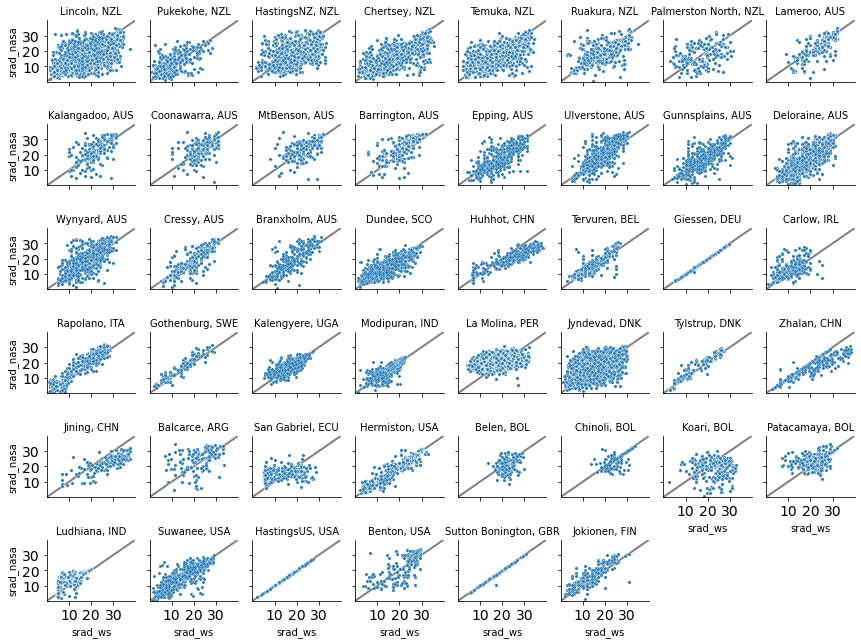

In [298]:
g = sns.FacetGrid(df2, col="isoloc", height=1.5, col_wrap=8)
g.map(sns.scatterplot, "srad_ws", "srad_nasa",zorder=2, s=10)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

xmax=39.9
ymax=39.9
# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=2,zorder=1)
    ax.set_title(ax.get_title(),fontsize=10)
    ax.set_ylabel('srad_nasa', fontsize='medium')
    ax.set_xlabel('srad_ws', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,39.9])
    ax.set_ylim([0.01,39.9])
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\NewSubmission\data\srad.png', dpi=300,bbox_inches='tight')

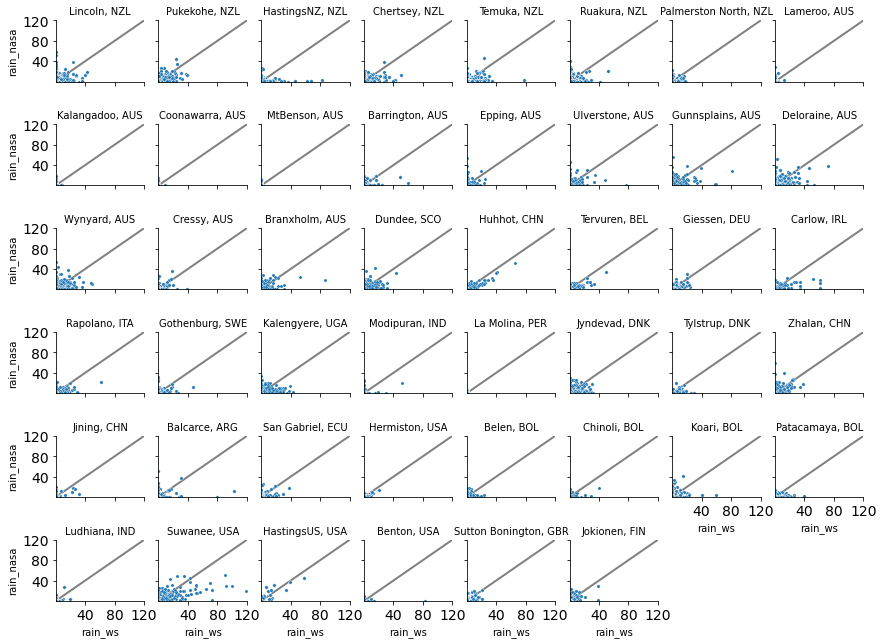

In [299]:
g = sns.FacetGrid(df2, col="isoloc", height=1.5, col_wrap=8)
g.map(sns.scatterplot, "rain_ws", "rain_nasa",zorder=2, s=10)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

xmax=120
ymax=120
# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.plot([0,xmax],[0,ymax],"-",color="grey", linewidth=2,zorder=1)
    ax.set_title(ax.get_title(),fontsize=10)
    ax.set_ylabel('rain_nasa', fontsize='medium')
    ax.set_xlabel('rain_ws', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(40))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([0.01,120])
    ax.set_ylim([0.01,120])
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\NewSubmission\data\rain.png', dpi=300,bbox_inches='tight')

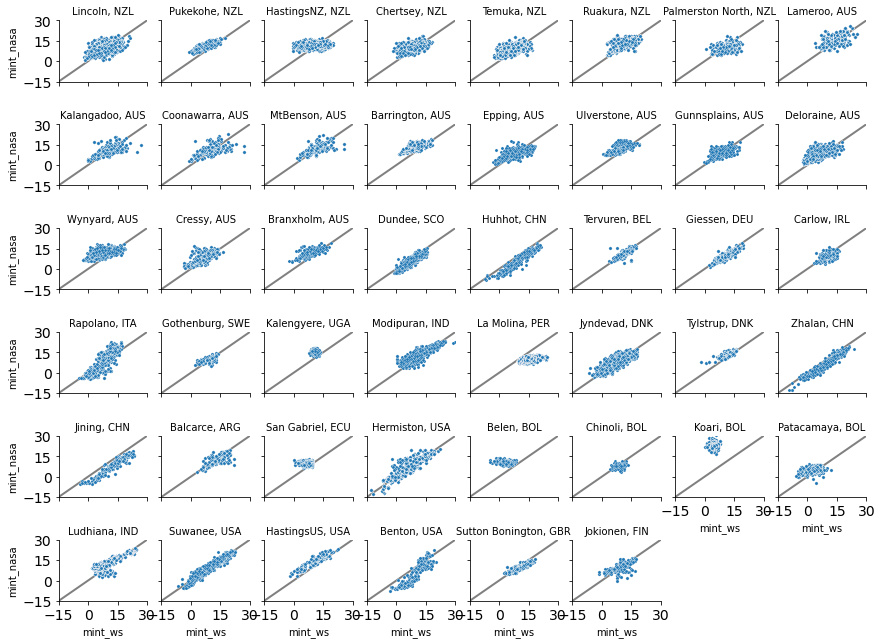

In [300]:
g = sns.FacetGrid(df2, col="isoloc", height=1.5, col_wrap=8)
g.map(sns.scatterplot, "mint_ws", "mint_nasa",zorder=2, s=10)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

xmax=30
ymax=30
# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.plot([-15,xmax],[-15,ymax],"-",color="grey", linewidth=2,zorder=1)
    ax.set_title(ax.get_title(),fontsize=10)
    ax.set_ylabel('mint_nasa', fontsize='medium')
    ax.set_xlabel('mint_ws', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(15))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([-15,30])
    ax.set_ylim([-15,30])
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\NewSubmission\data\mint.png', dpi=300,bbox_inches='tight')

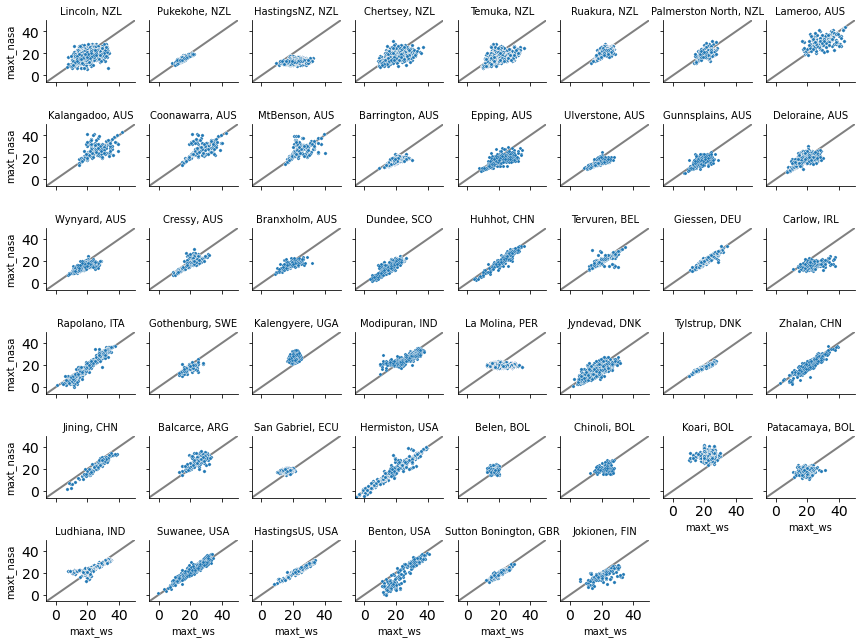

In [301]:
g = sns.FacetGrid(df2, col="isoloc", height=1.5, col_wrap=8)
g.map(sns.scatterplot, "maxt_ws", "maxt_nasa",zorder=2, s=10)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

xmax=50
ymax=50
# Iterate thorugh each axis
for ax in g.axes.flat:
    ax.plot([-6,xmax],[-6,ymax],"-",color="grey", linewidth=2,zorder=1)
    ax.set_title(ax.get_title(),fontsize=10)
    ax.set_ylabel('maxt_nasa', fontsize='medium')
    ax.set_xlabel('maxt_ws', fontsize='medium')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xlim([-6,50])
    ax.set_ylim([-6,50])
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\NewSubmission\data\maxt.png', dpi=300,bbox_inches='tight')

<AxesSubplot:xlabel='LeafBranchNo'>

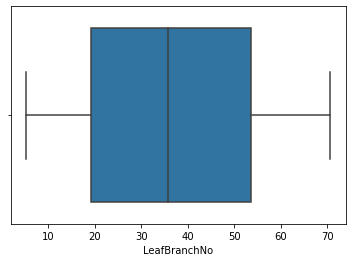

In [126]:
import seaborn as sns
sns.boxplot(x=Obs['LeafBranchNo'])
#Obs.boxplot()

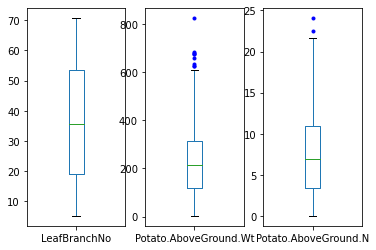

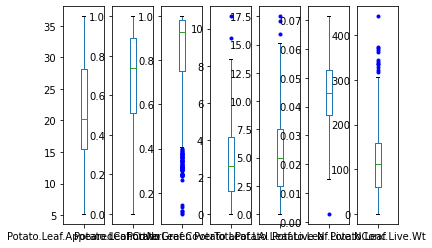

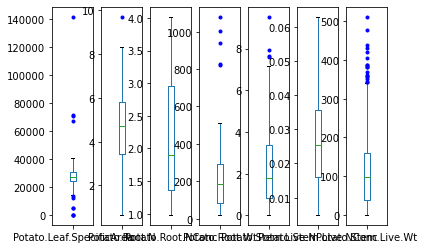

In [129]:
df_1 = Obs.iloc[:, 1:-1]

n_rows = 3
col_start = 0
delta = 7
col_end = 0


for i in range(n_rows):
    col_end = col_start + delta
    Obs.iloc[:, col_start:col_end].plot(kind = 'box', subplots=True, sym='b.')
    col_start += delta

plt.show()

In [36]:
#Remove 0 values from the observed file in Total Wt
c=data[data.obsToWt != 0]

#Remove Hermiston, something wierd is happening here
PreData=c[c.Loc != 'Hermiston']

#Create filters
#Removing outliers for population
df_final0 = PreData[PreData.PlantPopn > 3.875968992248062]
df_final1 = df_final0[df_final0.PlantPopn < 5.555555555555555]

#Removing winter sowing
a=df_final1[df_final1.Experiment != 'CPLM8501INVIERNO']

#Removing high latitudes
b=a[a.lat < 40 ]

#Removing high latitudes
PostData=b[b.Loc != 'La Molina']

#Adding month and day of sowing as columns
PostData['SowDate0']  = pd.to_datetime(PostData['PlantingDate'])
PostData['SowDate'] = PostData['SowDate0'].dt.strftime('%Y-%m-%d')
PostData['month'] = PostData['SowDate'].str[5:7]
PostData['day'] = PostData['SowDate'].str[8:10]
PreData['SowDate0']  = pd.to_datetime(PreData['PlantingDate'])
PreData['SowDate'] = PreData['SowDate0'].dt.strftime('%Y-%m-%d')
PreData['month'] = PreData['SowDate'].str[5:7]
PreData['day'] = PreData['SowDate'].str[8:10]

<ipython-input-36-5cd489bf461c>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PostData['SowDate0']  = pd.to_datetime(PostData['PlantingDate'])
<ipython-input-36-5cd489bf461c>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PostData['SowDate'] = PostData['SowDate0'].dt.strftime('%Y-%m-%d')
<ipython-input-36-5cd489bf461c>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

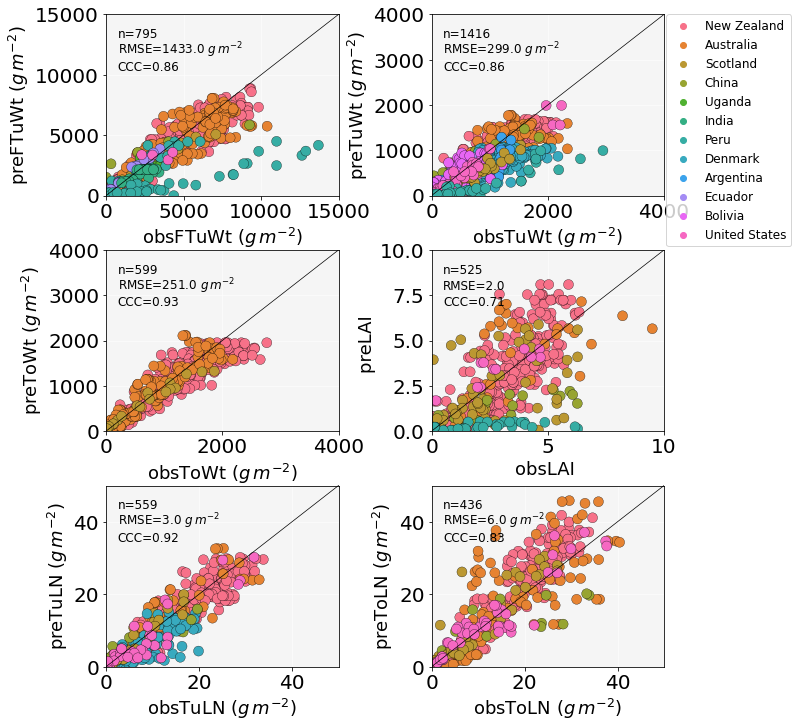

In [40]:
kwargs  =   {'edgecolor':"k"}

fig = plt.figure(figsize=(10,12))

ax=plt.subplot(3, 2, 1)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=15000
ymax=15000
sns.scatterplot(x='obsFTuWt', y='preFTuWt', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preFTuWt ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsFTuWt ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsFTuWt'].notna()]

Obs = pd.Series(df_finalSt.obsFTuWt.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preFTuWt.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 2)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=4000
ymax=4000
sns.scatterplot(x='obsTuWt', y='preTuWt', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preTuWt ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsTuWt ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsTuWt'].notna()]

Obs = pd.Series(df_finalSt.obsTuWt.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preTuWt.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')


ax=plt.subplot(3, 2, 3)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=4000
ymax=4000
sns.scatterplot(x='obsToWt', y='preToWt', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preToWt ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsToWt ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsToWt'].notna()]

Obs = pd.Series(df_finalSt.obsToWt.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preToWt.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 4)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=10
ymax=10
sns.scatterplot(x='obsLAI', y='preLAI', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preLAI ', fontsize =18)
plt.xlabel('obsLAI ', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsLAI'].notna()]

Obs = pd.Series(df_finalSt.obsLAI.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preLAI.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 5)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=50
ymax=50
sns.scatterplot(x='obsTuLN', y='preTuLN', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preTuLN ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsTuLN ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsTuLN'].notna()]

Obs = pd.Series(df_finalSt.obsTuLN.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preTuLN.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

ax=plt.subplot(3, 2, 6)

#ax.set_title('15km x 15km',fontsize= 25,weight='bold') 
#ax.title.set_position([0.5,1.01])
xmax=50
ymax=50
sns.scatterplot(x='obsToLN', y='preToLN', hue='Country',
                alpha=1, data=PreData,linewidth=0.3,**kwargs, s=100)
plt.plot([0,xmax],[0,ymax],"-",color="k", linewidth=0.7)
plt.legend(prop=dict(size=15),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# Formatting graph and background
plt.ylabel('preToLN ($g\,m^{-2}$)', fontsize =18)
plt.xlabel('obsToLN ($g\,m^{-2}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)

#Taking data from dataframe to a list

df_finalSt = PreData[PreData['obsToLN'].notna()]

Obs = pd.Series(df_finalSt.obsToLN.values)
y_o= Obs.tolist()
Pre = pd.Series(df_finalSt.preToLN.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=0)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
plt.text(xmax*0.05, ymax*0.87,'n='+N,fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.78,'RMSE='+RMSE+' $g\,m^{-2}$',fontsize=12,color='k')
plt.text(xmax*0.05, ymax*0.69,'CCC='+CCC,fontsize=12,color='k')
ax.get_legend().remove()

plt.subplots_adjust(wspace=0.4, hspace=0.3)
#plt.savefig(r'C:\Users\uqjojeda\Dropbox\APSIMPotato\Paper docs\Paper 1\data\PreDataSowDate.png', dpi=300,bbox_inches='tight')